In [1]:
import sys
sys.path.append("../..")
sys.path.append("../../sac_ae")

In [2]:
import numpy as np
import torch
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import gym
from IPython import display
from ipywidgets import Output, GridspecLayout
sns.set_theme()

In [3]:
from sac_ae.env import make_envs
from sac_ae.model import make_model
from sac_ae.agent import make_agent
from memory import ReplayBufferStorage, make_replay_buffer, ReplayBufferDataset, ReplayBuffer, ReplayBufferStorageCost, ReplayBufferDatasetCost, ReplayBufferCost, load_episode
from utils.misc import eval_mode, VideoRecorder
from utils.argument import Arguments

In [4]:
def load_agent_and_args(path, device=torch.device('cpu')):
    args = Arguments(path + 'args.json')
    weights = torch.load(path + 'model/best_model.pt', map_location=device)

    if args.agent == 'sac_state':
        agent_obs_shape = weights['actor.encoder.projection.projection.0.weight'].shape[1:]
        args.agent_image_size = agent_obs_shape[0]
    else:
        agent_obs_shape = (3*args.frame_stack, args.agent_image_size, args.agent_image_size)
    action_shape = np.array([4])

    model = make_model(agent_obs_shape, action_shape, args, device)
    agent = make_agent(model, device, action_shape, args)
    agent.load_model_from_dict(weights)
    return agent, args

In [5]:
device = torch.device('cuda')
agent, args = load_agent_and_args('../../sac_ae/log/CustomFetchPushCostSmallDense-v0-09-29-09-56-im84-b256-s1-drq/')

In [6]:
args.pr_model_name_list = None

In [7]:
pixel_env = make_envs(args, is_eval=True, use_state=args.agent == 'sac_state')
state_env = gym.make(args.env_name)

In [8]:
from sac_ae.env import make_ensemble

In [9]:
args.pr_files = '../../../output/fetch-push-cost-small-'

In [10]:
ensemble = make_ensemble(args, np.array([4]))

In [11]:
pixel_env.seed(0)
state_env.seed(0)
pixel_obs = pixel_env.reset()
state_obs = state_env.reset()

Creating window glfw


In [12]:
def calc_action_error(observation, action) -> float:
    preference_action, confidence = ensemble.calc_action(observation)
    if not args.pr_keep_last_dim:
        action_error = ((action[:-1] - preference_action[:-1])**2).mean()
    else:
        action_error = ((action - preference_action)**2).mean()
    return action_error, confidence

In [26]:
ensemble.teach_per_episode = True
ensemble.teacher = 2

In [30]:
ensemble.teach_per_episode = False

In [31]:
seed = 4
pixel_env.seed(seed)
state_env.seed(seed)
pixel_obs = pixel_env.reset()
state_obs = state_env.reset()

episode_reward, episode_cost = 0, 0
done = False
action_errors = []
confidences = []

pixel_video = VideoRecorder('./ensemble_analysis')
state_video = VideoRecorder('./ensemble_analysis')

pixel_video.init()
pixel_video.record(pixel_env)
state_video.init()
state_video.record(state_env)

while not done:
    with eval_mode(agent):
        action = agent.select_action(pixel_obs)

    action_error, confidence = calc_action_error(state_obs, action)
    action_errors.append(action_error)
    confidences.append(confidence)

    pixel_obs, reward, done, info = pixel_env.step(action)
    state_obs, _, _, _ = state_env.step(action)
    
    
    pixel_video.record(pixel_env)
    state_video.record(state_env)
    
    episode_reward += reward
    if args.cost != 'no_cost':
        episode_cost += info['cost']
        
pixel_video.save('pixel_video.mp4')
state_video.save('state_video.mp4')

In [32]:
grid = GridspecLayout(1, 2)
for i, name in enumerate(['pixel_video.mp4', 'state_video.mp4']):
    out = Output()
    with out:
        display.display(display.Video(f'ensemble_analysis/{name}', html_attributes='loop autoplay', embed=True))
    grid[0, i] = out
grid

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

Text(0.5, 1.0, 'Confidence')

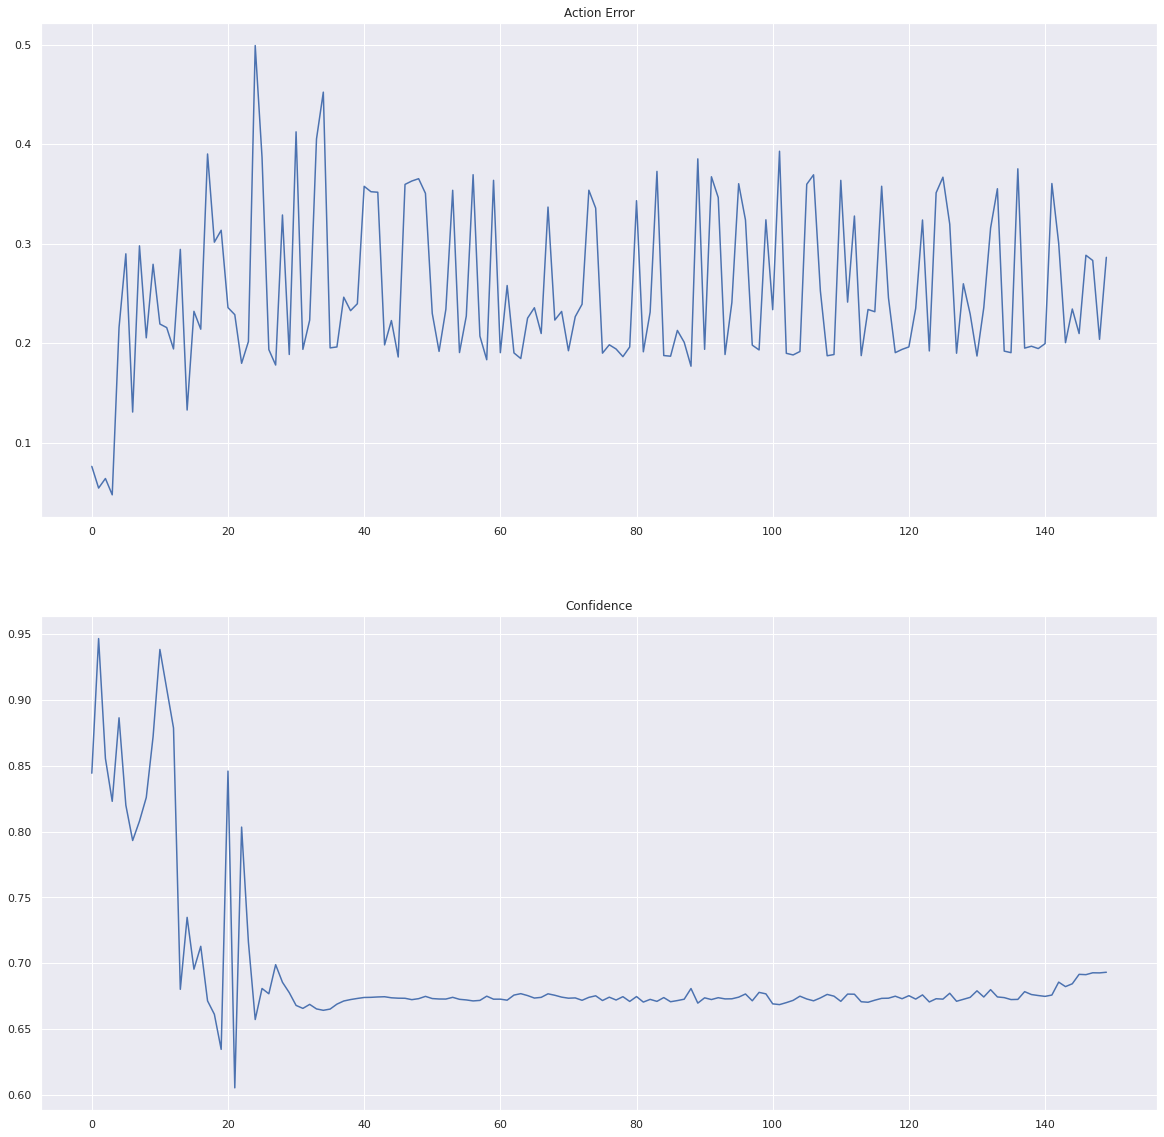

In [33]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(2, 1, 1)
sns.lineplot(data=action_errors, label=f'Ensemble {i}', legend=False)
ax.set_title('Action Error')
ax = fig.add_subplot(2, 1, 2)
sns.lineplot(data=confidences, label=f'Ensemble {i}', legend=False)
ax.set_title('Confidence')